# Aviation Data Analysis 

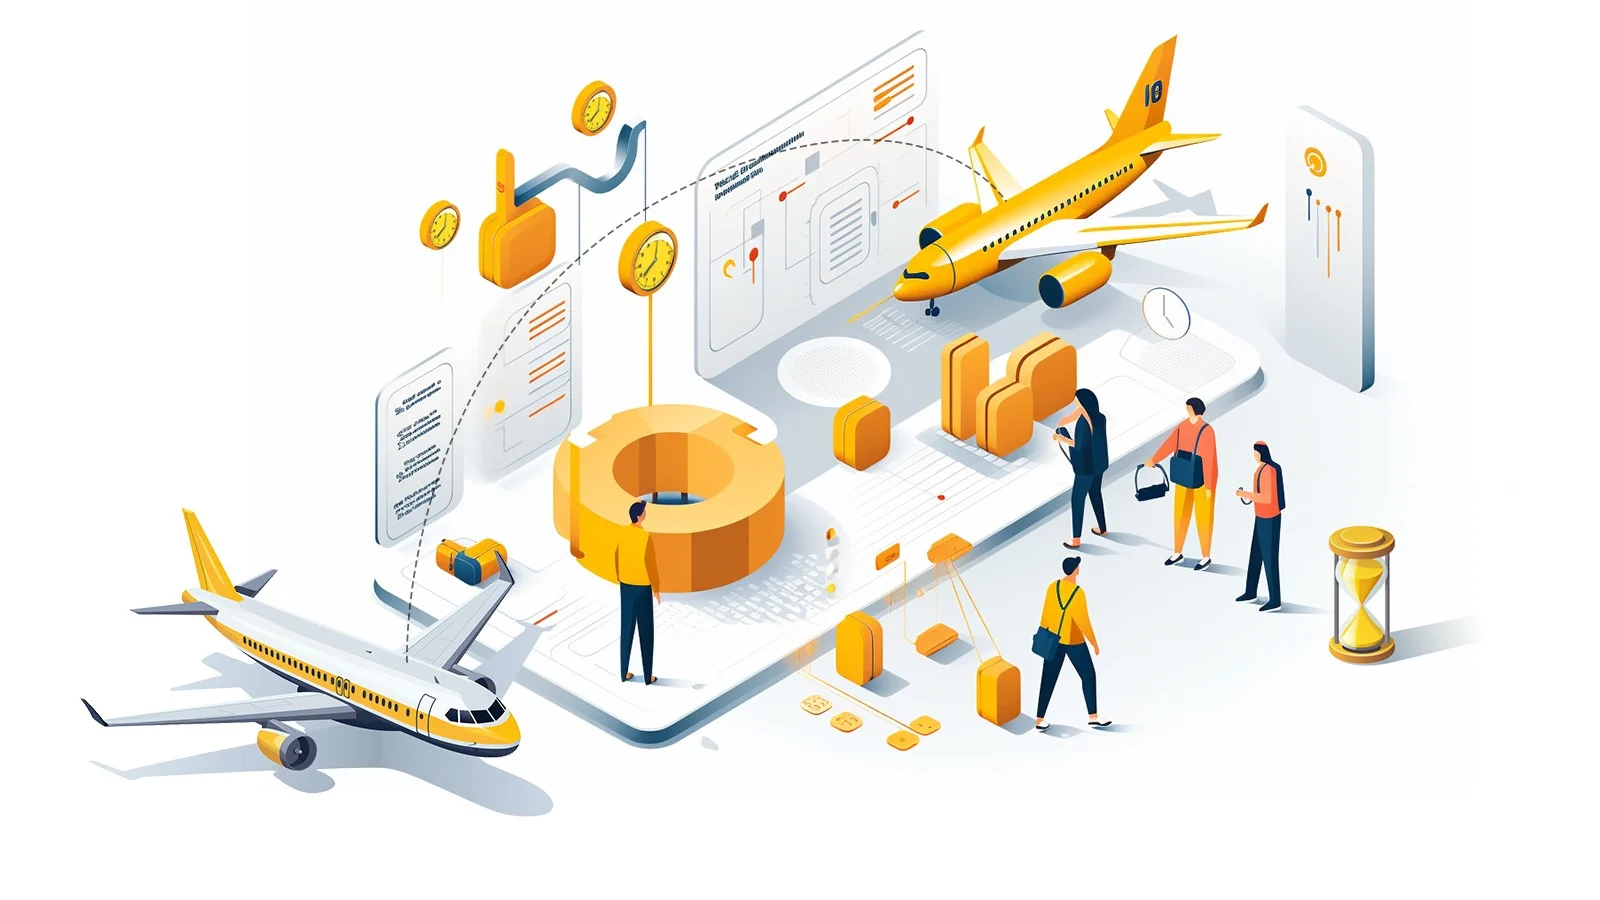

## Overview

This project analyzes problematic flights in an attempt to understand what\
factors may lead to undesired occurrences during these flights. Descriptive \
analysis of this data shows that certain factors such as the type of engine\
or aircraft size may point to which types are aircraft are more prone to \
fatal incidents. My company can use this analysis to help understand the \
risks of investing in different types of airplane operations.



## Business Problem

My company would like to invest in new industries to diversify its portfolio.\
Specifically, they are interested in purchasing and operating airplanes for\
commercial and private enterprises but first need to learn more about the \
potential risks of different kinds of aircraft. Shedding light on these risks\
could help guide my company to make aircraft operation selections that are less\
problematic. By using the NTSB Aviation Accident Dataset I describe patterns in\
engine types, aircraft passenger capacities, and operation regional locations to\
help anticipate which aircraft will have the lowest accident fatality rates.

## Data Understanding

put a picture here

The NTSB aviation accident database includes information on civil aviation\
accidents and certain incidents from 1962 onward, covering the United States,\
its territories and possessions, as well as international waters.

In [1]:
#Import the relevant libraries to help us view and manipulate the data.

import numpy as np
import pandas as pd 

In [23]:
#Convert the CSV file into a dataframe.

#low_memory= False ells Pandas to read the entire file into memory at once, 
#instead of processing it in sections.

Aviation_Data= pd.read_csv('data/Aviation_Data.csv', low_memory=False)

## Aircraft Data

This dataset has 90,348 records of problematic flights from 1962 to 2023 with\
93% of these data points coming from the USA. Each record refers to the date,\
location, and severity of each event, along with information about the type of\
aircraft involved in the incident (i.e. make, model, engine type...). 

In [24]:
#A preview of what the dataframe looks like.

Aviation_Data.head(3)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007


In [25]:
#A description of the Dataframe and the types of data in it.

Aviation_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

## Data Preperation

### Data Cleaning and Trimming


To make the Dataframe easier to manipulate for analysis, I will drop\
irrelevant columns, normalize column names/values, and filter out irrelevant data\
points. In addition to this, where needed, instead of estimating and imputing new\
values, I will drop all rows that are missing relevant data. This is done to avoid\
creating an over-representation bias in the dataset. 

This analysis will specifically focus on which Jet operations pose the lowest\
risks in America. Due to this, I will be filtering out the following. All instances\
where the aircraft is not an "Airplane", all instances where the country is not\
"United States", all aircraft that was not professionally built, and all aircraft that\
does not use a type of Jet engine.

Taking these steps will get the Dataframe ready for feature engineering. 

In [26]:
#Narrow the Dataframe down to only relevant columns. 

Rel_Aviation_Data= Aviation_Data[['Event.Id','Aircraft.Category','Amateur.Built',
                                  'Engine.Type', 'Total.Fatal.Injuries', 
                                  'Total.Serious.Injuries', 'Total.Minor.Injuries', 
                                  'Total.Uninjured','Event.Date','Location',
                                  'Country','Weather.Condition']].copy()

In [27]:
#Normalize the data in the Weather.Condition column.

Rel_Aviation_Data['Weather.Condition']= Rel_Aviation_Data['Weather.Condition'].str.title()

In [28]:

#Drop all data instances where the type of aircraft is not an Airplane.
Rel_Aviation_Data= Rel_Aviation_Data[Rel_Aviation_Data['Aircraft.Category']== 'Airplane']

#Drop all data instances where the Country of incident is not United States.
Rel_Aviation_Data= Rel_Aviation_Data[Rel_Aviation_Data['Country']== 'United States']

#Drop all data instances where the aircraft is not professionally built. This is
#done to avoid any bias from incidents that may be due to faulty assembly.
Rel_Aviation_Data= Rel_Aviation_Data[Rel_Aviation_Data['Amateur.Built']== 'No']

#Drop all data instances where the aircraft does not use a type of Jet engine.
Rel_Aviation_Data= Rel_Aviation_Data[Rel_Aviation_Data['Engine.Type'].isin(['Turbo Fan', 
                                                                            'Turbo Jet', 
                                                                            'Turbo Prop'])]

#Drop all data instances where the weather condition is unknown. 
Rel_Aviation_Data= Rel_Aviation_Data[Rel_Aviation_Data['Weather.Condition'].isin(['Vmc', 
                                                                            'Imc'])]

After reviewing the injury and fatality counts rows I discovered that the NaN values in \
these columns are used in place of 0. These NaN values can be problematic for numeric\
feature engineering so I will create a function to convert them to 0.

In [29]:
#A function that replaces all the NaN values in a column to the number 0.
def Nan_Stripper(cols):
    for x in cols:
        Rel_Aviation_Data[x]= Rel_Aviation_Data[x].fillna(0)

#Applying the NaN convertor function to the relevant columns.
Nan_Stripper(['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries',
              'Total.Uninjured'])

In [30]:
#Drop all duplicates to help avoid over-representation bias.
Jet_Data= Rel_Aviation_Data.drop_duplicates() 

In [31]:
#Preview of the cleaned and filtered Dataset
Jet_Data.head(3)

,Event.Id,Aircraft.Category,Amateur.Built,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Event.Date,Location,Country,Weather.Condition
5,20170710X52551,Airplane,No,Turbo Fan,0.0,0.0,1.0,44.0,1979-09-17,"BOSTON, MA",United States,Vmc
80,20020917X01765,Airplane,No,Turbo Prop,0.0,0.0,0.0,2.0,1982-01-12,"CLARKSBURG, WV",United States,Vmc
93,20020917X02538,Airplane,No,Turbo Prop,0.0,1.0,2.0,12.0,1982-01-15,"JAMAICA, NY",United States,Vmc


In [32]:
#Description of the data in the filtered and cleaned Dataset
Jet_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1941 entries, 5 to 89851
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                1941 non-null   object 
 1   Aircraft.Category       1941 non-null   object 
 2   Amateur.Built           1941 non-null   object 
 3   Engine.Type             1941 non-null   object 
 4   Total.Fatal.Injuries    1941 non-null   float64
 5   Total.Serious.Injuries  1941 non-null   float64
 6   Total.Minor.Injuries    1941 non-null   float64
 7   Total.Uninjured         1941 non-null   float64
 8   Event.Date              1941 non-null   object 
 9   Location                1941 non-null   object 
 10  Country                 1941 non-null   object 
 11  Weather.Condition       1941 non-null   object 
dtypes: float64(4), object(8)
memory usage: 197.1+ KB


## Feature Engineering

Feature engineer new columns to help assist analize what Jet operations have the lowest\
risks in operating.

In [35]:
#Create column Incident.Severity that shows 1 if an incident has fatalities and 0 if not.
Jet_Data['Incident.Severity']=Jet_Data['Total.Fatal.Injuries'].map(lambda x:1 if x >= 1 \
                                                                   else 0)

#Create a column "State" that extracts the state from the location column.
Jet_Data['State']= Jet_Data['Location'].str[-2:]

#Create a column "Year" that extracts the year from the Event.Date column.
Jet_Data['Year']= Jet_Data['Event.Date'].str[:4]

#Creation of lists that sort states into regions of the USA.
West= ['WA','OR','CA','HI','AK','ID','NV','MT','WY','UT','CO','AZ','NM']
Midwest= ['ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH']
Northeast= ['PA','NY','NJ','CT','RI','MA','VT','NH','ME']
South= ['TX','OK','AR','LA','KY','TN','MS','AL','WV','DE','MD','DC','VA','NC','SC','GA','FL']

#Creation of function that sorts states into regions.
def where_am_i(x):
    if x in West:
        return 'West'
    elif x in Midwest:
        return 'Midwest'
    elif x in Northeast:
        return 'Northeast'
    elif x in South:
        return 'South'

#Create a column "Region" that displays what region of the USA the incident took place in.
Jet_Data['Region']= Jet_Data['State'].apply( lambda x : where_am_i(x))

#Create a column "Number.of.Passengers" that shows the number of passengers on an
#aircraft. This will help show the passenger capacity (size) of each aircraft. This
#is done by adding up all the passengers from the injury level columns.
Jet_Data['Number.of.Passengers']=Jet_Data['Total.Fatal.Injuries']\
                                            +Jet_Data['Total.Serious.Injuries']\
                                            +Jet_Data['Total.Minor.Injuries']\
                                            +Jet_Data['Total.Uninjured']

#Create a function that sorts the aircrafts into a size based on the number of 
#passengers they can hold.
def size_selector(x):
    if x <= 10:
        return 'Personal'
    elif 11 <= x <= 50:
        return 'Small'
    elif 51 <= x <= 100:
        return 'Medium'
    elif 101 <= x <= 200:
        return 'Large'
    else:
        return 'Jumbo'

#Create a column "Aircraft.Size" that shows what size the aircraft in the incident is. 
Jet_Data['Aircraft.Size']= Jet_Data['Number.of.Passengers'].apply( lambda x : \
                                                                  size_selector(x))

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_54469/1751220689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Jet_Data['Incident.Severity']=Jet_Data['Total.Fatal.Injuries'].map(lambda x:1 if x >= 1 \
/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_54469/1751220689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Jet_Data['State']= Jet_Data['Location'].str[-2:]
/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_54469/1751220689.py:9: SettingWithCopyWarning: 
A value is

In [36]:
#Preview of the Dataset with the new feature engineered columns.
Jet_Data.head(3)

,Event.Id,Aircraft.Category,Amateur.Built,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Event.Date,Location,Country,Weather.Condition,Incident.Severity,State,Year,Region,Number.of.Passengers,Aircraft.Size
5,20170710X52551,Airplane,No,Turbo Fan,0.0,0.0,1.0,44.0,1979-09-17,"BOSTON, MA",United States,Vmc,0,MA,1979,Northeast,45.0,Small
80,20020917X01765,Airplane,No,Turbo Prop,0.0,0.0,0.0,2.0,1982-01-12,"CLARKSBURG, WV",United States,Vmc,0,WV,1982,South,2.0,Personal
93,20020917X02538,Airplane,No,Turbo Prop,0.0,1.0,2.0,12.0,1982-01-15,"JAMAICA, NY",United States,Vmc,0,NY,1982,Northeast,15.0,Small


save the cleaned dataset as a csv


In [37]:
#Save is cleaned and feature engineered dataset as a .CSV file for use elsewhere. 
Jet_Data.to_csv('./data2/Jet_Data.csv')

## Analysis

In [38]:
#Import library to help display data analysis 
import matplotlib.pyplot as plt
%matplotlib inline

### Region of Operation

The Dataset places the weather conditions experienced during each incident into one\
of two categories. The first option is VMC (Visual Meteorological Conditions) which\
often is considered the safer of the two options due to the pilot's ability to navigate\
the aircraft based on visual references. The second option is IMC (Instrument\
Meteorological Conditions) which is the more problematic and usually accident-prone of\
the two options due to the pilot needing to rely on flight instruments due to lack of\
visibility and rough weather. 

In an effort to analyze which area of the USA is the safest to operate these Jets\
in, I will run an analysis to see which region of the USA experienced the least amount\
of incidents with IMC flight conditions. 

In [16]:
Regional_Weather=Jet_Data[['Weather.Condition', 'Region']]

Regional_IMC_Weather=Regional_Weather[Regional_Weather['Weather.Condition']=='Imc']

Regional_IMC_Weather_Series= Regional_IMC_Weather.groupby(['Region'])\
['Weather.Condition'].count()

Regional_IMC_DF=Regional_IMC_Weather_Series.to_frame()

Regional_IMC_DF.rename(columns={'Weather.Condition':\
    'Imc.Weather.Events'},inplace=True)

Regional_IMC_DF.reset_index(inplace=True)

Regional_IMC_DF

,Region,Imc.Weather.Events
0,Midwest,63
1,Northeast,36
2,South,103
3,West,67


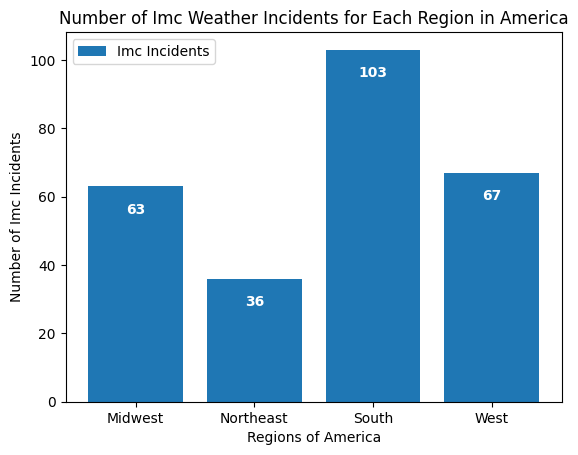

In [17]:
#Regional Weather Analysis

x= Regional_IMC_DF['Region']
y= Regional_IMC_DF['Imc.Weather.Events']

Imc_Weather_Fig, Imc_Weather_Axes= plt.subplots()
Imc_Weather_plt=Imc_Weather_Axes.bar(x,y)


for event in Imc_Weather_plt:
    height= event.get_height()
    Imc_Weather_Axes.annotate(f'{height}', xy=(event.get_x() + event.get_width() / 2,\
                            height-10), xytext=(0,3), textcoords= 'offset points',\
                               ha= 'center', va= 'bottom', color= 'white',\
                               fontweight= 'bold')

Imc_Weather_Axes.set_title(\
    'Number of Imc Weather Incidents for Each Region in America')
Imc_Weather_Axes.set_ylabel('Number of Imc Incidents')
Imc_Weather_Axes.set_xlabel('Regions of America')

Imc_Weather_Axes.legend([Imc_Weather_plt], \
                              ['Imc Incidents'], \
                              loc = 'upper left')

plt.savefig("./images2/Regional_Weather_Analysis_Distribution.png", dpi=150)
plt.show()

### Size of Jet (Number of Passengers)

talk about the analysis 

show the analysis

In [18]:
Jet_Size=Jet_Data[['Aircraft.Size', 'Incident.Severity']]

Jet_Size_Series= Jet_Size.groupby(['Aircraft.Size'])\
['Incident.Severity'].count()

Jet_Size_DF=Jet_Size_Series.to_frame()

Jet_Size_DF.rename(columns={'Incident.Severity':\
    'Fatal.Events'},inplace=True)

Jet_Size_DF.reset_index(inplace=True)

Jet_Size_DF

,Aircraft.Size,Fatal.Events
0,Jumbo,56
1,Large,180
2,Medium,97
3,Personal,1481
4,Small,127


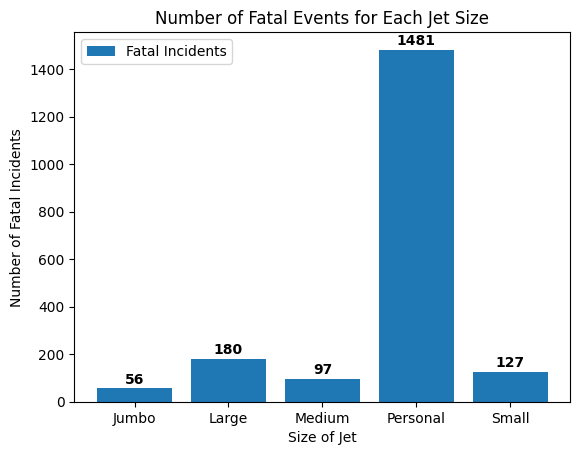

In [19]:
#Jet Size Analysis

x= Jet_Size_DF['Aircraft.Size']
y= Jet_Size_DF['Fatal.Events']

Aircraft_Size_Fig, Aircraft_Size_Axes= plt.subplots()
Aircraft_Size_plt=Aircraft_Size_Axes.bar(x,y)


for size in Aircraft_Size_plt:
    height= size.get_height()
    Aircraft_Size_Axes.annotate(f'{height}', xy=(size.get_x() + size.get_width() / 2,\
                            height-10), xytext=(0,3), textcoords= 'offset points',\
                               ha= 'center', va= 'bottom', color= 'black',\
                               fontweight= 'bold')

Aircraft_Size_Axes.set_title(\
    'Number of Fatal Events for Each Jet Size')
Aircraft_Size_Axes.set_ylabel('Number of Fatal Incidents')
Aircraft_Size_Axes.set_xlabel('Size of Jet')

Aircraft_Size_Axes.legend([Aircraft_Size_plt], \
                              ['Fatal Incidents'], \
                              loc = 'upper left')

plt.savefig("./images2/Aircraft_Size_Analysis_Distribution_2.png", dpi=150)
plt.show()

### Type of Jet Engine

talk about the analysis

show the analysis

In [20]:
Jet_Engine_Type=Jet_Data[['Engine.Type', 'Incident.Severity']]

Jet_Engine_Type_Series= Jet_Engine_Type.groupby(['Engine.Type'])\
['Incident.Severity'].count()

Jet_Engine_Type_DF=Jet_Engine_Type_Series.to_frame()

Jet_Engine_Type_DF.rename(columns={'Incident.Severity':\
    'Fatal.Events'},inplace=True)

Jet_Engine_Type_DF.reset_index(inplace=True)

Jet_Engine_Type_DF

,Engine.Type,Fatal.Events
0,Turbo Fan,616
1,Turbo Jet,132
2,Turbo Prop,1193


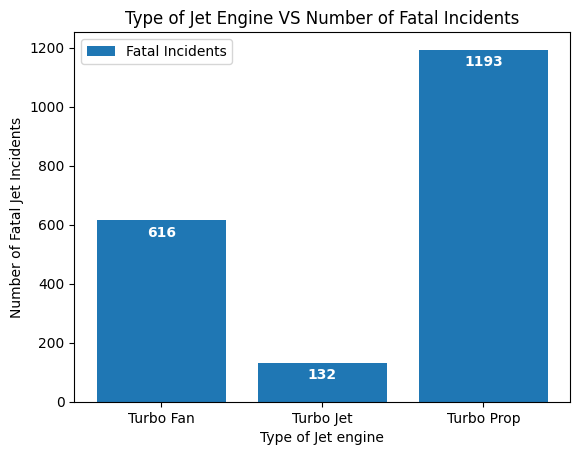

In [21]:
#Jet Engine Type Analysis

x= Jet_Engine_Type_DF['Engine.Type']
y= Jet_Engine_Type_DF['Fatal.Events']

Jet_Engine_Fig, Jet_Engine_Axes= plt.subplots()
Fatal_Jet_Incidents_plt=Jet_Engine_Axes.bar(x,y)

for FEng in Fatal_Jet_Incidents_plt:
    height= FEng.get_height()
    Jet_Engine_Axes.annotate(f'{height}', xy=(FEng.get_x() + FEng.get_width() / 2,\
                            height-80), xytext=(0,3), textcoords= 'offset points',\
                               ha= 'center', va= 'bottom', color= 'white',\
                               fontweight= 'bold')


Jet_Engine_Axes.set_title(\
    'Type of Jet Engine VS Number of Fatal Incidents')
Jet_Engine_Axes.set_ylabel('Number of Fatal Jet Incidents')
Jet_Engine_Axes.set_xlabel('Type of Jet engine')

Jet_Engine_Axes.legend([Fatal_Jet_Incidents_plt], \
                              ['Fatal Incidents'], \
                              loc = 'upper left')

plt.savefig("./images2/Jet_Engine_Fatal_Incident_Distrobution.png", dpi=150)
plt.show()

## Conclusions

This analysis resulted in 3 recommendations for investing in a new jet operation. 

1) Invest in jets that mainly operate in the Northeast region of the USA. In\
    terms of weather conditions, it is more difficult to operate aircraft during\
    Instrument Meteorological Conditions (IMC) than Visual Meteorological\
    Conditions (VMC). According to this dataset, from 1962 to 2023, The Northeast\
    region of America, compared to the other regions of America, has experienced\
    the fewest fatal jet incidents that took place during IMC. 

2) Invest in jets that have larger passenger-carrying capacities. According\
   to this dataset, in America, jets with the capacity to carry over 50 people\
   have experienced over 3X fewer fatal incidents than jets that can only carry\
   50 or less people.

4) Invest in Airplanes that utilize Turbo Jet Engines as a method of propulsion.\
   According to this dataset, in America, airplanes that use Turbo Jet Engines\
   have experienced a lower amount of fatal incidents, than other jet engine\
   types, over a 60 year span.  


### Next Steps

Additional analysis could help further minimize the risk our company takes on\
when selecting a new aircraft operation to invest in by bringing additional\
insights to light. 

1) Jet improvement analysis. This model could display which types of jets\
   have improved the most over the years and now have a smaller chance of\
   experiencing a fatal incident.
    
2) Flight purpose analysis. This model could display which types of flights\
    are more prone to experiencing fatal incidents. 
    
3) Risk predictor model. Given details about a potential flight, this model\
    could help predict the level of incident severity a flight could result in. 